In [1]:
import sys
sys.path.append("../../")

import bayesflow as bf
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from bayesflow.experimental.rectifiers import RectifiedDistribution
from amortizers import ConsistencyAmortizer, ConfigurableMLP, DriftNetwork

2023-11-30 09:45:19.900302: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 09:45:19.923330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 09:45:20.248547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/radevs/anaconda3/envs/BayesFlowDev/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonot

## Data Loading and Configuration

In [2]:
def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
    assert(len(obs_path) == len(param_path))
    observables = []
    params = []
    for i in range(len(obs_path)):
        observables.append(pd.read_pickle(obs_path[i]))
        params.append(pd.read_pickle(param_path[i]))
    obs = np.stack(pd.concat(observables).to_numpy())
    tumor_size = np.stack(obs[:,0])[:, :, None].astype(np.float32)
    radial_features = np.stack([np.stack(obs[:,1]),np.stack(obs[:,2])], axis=-1)[:,:300,:].astype(np.float32)
    params = pd.concat(params).to_numpy().astype(np.float32)
    split = int(validation_ratio * params.shape[0])
    train = {"prior_draws": params[split:], 
             "sim_data": radial_features[split:], 
             'growth_curve': tumor_size[split:]}
    validation = {"prior_draws": params[:split], 
                  "sim_data": radial_features[:split], 
                  'growth_curve': tumor_size[:split]}    
    return train, validation

In [3]:
def configure_input(forward_dict):
    """Custom configurator."""
    
    out_dict = {}
    pp_ecmp = (forward_dict['sim_data'] - MEAN_SIM) / STD_SIM
    pp_ecmp = np.c_[pp_ecmp, [POSITIONAL_EMBEDDINGS]*pp_ecmp.shape[0]]
    growth =  (forward_dict['growth_curve'] - MEAN_GROWTH) / STD_GROWTH 
    params = forward_dict['prior_draws']
    
    out_dict = {
        'summary_conditions': (pp_ecmp, growth),
        'parameters': params
    }    
    return out_dict

In [4]:
train_data, val_data = read_offline_data(
    obs_path=['../../tumor_data/observables_10000_1.pkl', '../../tumor_data/observables_10000_2.pkl'],
    param_path=['../../tumor_data/params_10000_1.pkl', '../../tumor_data/params_10000_2.pkl']
)

In [5]:
MEAN_GROWTH = train_data['growth_curve'].mean((0, 1))
STD_GROWTH = train_data['growth_curve'].std((0, 1))
MEAN_SIM = train_data['sim_data'].mean((0, 1))
STD_SIM = train_data['sim_data'].std((0, 1))

## Networks

In [6]:
class CustomSummary(tf.keras.Model):
    def __init__(self, num_summary=32, num_dense_concat=2):
        super().__init__()    

        self.lstm = tf.keras.layers.LSTM(num_summary // 2)
        self.att_dict = {
            'num_heads': 4,
            'dropout': 0.1,
            'key_dim': 64
        }
        self.dense_dict = {
            'units': 128,
            'activation': 'relu',
            'kernel_regularizer': tf.keras.regularizers.L2(1e-4),
            'bias_regularizer': tf.keras.regularizers.L2(1e-4)
        }
        self.transformer = bf.networks.TimeSeriesTransformer(
            input_dim=3,
            attention_settings=self.att_dict,
            dense_settings=self.dense_dict,
            template_dim=32,
            summary_dim=num_summary
        )  
        dense_layers = []
        for l in range(num_dense_concat):
            dense_layers.append(
                tf.keras.layers.Dense(
                    units=256, 
                    activation='swish', 
                    kernel_regularizer=tf.keras.regularizers.L2(1e-4),
                    bias_regularizer=tf.keras.regularizers.L2(1e-4)
                )
            )
        self.fc = tf.keras.Sequential(dense_layers)
        self.fc.add(tf.keras.layers.Dense(num_summary))

    def call(self, summary_conditions, **kwargs):
        pp_ecmp, growth = summary_conditions        
        out1 = self.lstm(growth, **kwargs)
        out2 = self.transformer(pp_ecmp, **kwargs)        
        out = tf.concat([out1, out2], axis=-1)
        out = self.fc(out, **kwargs)        
        return out

In [7]:
BATCH_SIZE = 64
EPOCHS = 500
POSITIONAL_EMBEDDINGS = np.linspace(0, 1, train_data['sim_data'].shape[1], dtype=np.float32)[:, None]

In [8]:
ITERATIONS = int(np.ceil((train_data['sim_data'].shape[0] / BATCH_SIZE))*EPOCHS)

In [9]:
summary_net = CustomSummary()

inference_net = ConfigurableMLP(
    input_dim=train_data['prior_draws'].shape[-1],
    condition_dim=32,
    hidden_dim=256,
    num_hidden=4,
    dropout_rate=0.2,
)

amortizer = ConsistencyAmortizer(
    consistency_net=inference_net, 
    num_steps=ITERATIONS, 
    summary_net=summary_net,
    sigma2=tf.math.reduce_variance(train_data['prior_draws'], axis=0, keepdims=True),
    T_max=50
)

2023-11-30 09:45:21.998035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 09:45:22.012495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 09:45:22.012590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
schedule = tf.keras.optimizers.schedules.CosineDecay(1e-4, ITERATIONS, name="lr_decay")
optimizer = tf.keras.optimizers.Adam(schedule, clipnorm=1.0)

## Consistency Trainer

In [11]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    configurator=configure_input,
    checkpoint_path='ckpt/cm',
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


In [12]:
h = trainer.train_offline(
    train_data, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_sims=val_data,
    optimizer=optimizer
)

Training epoch 1:   0%|          | 0/307 [00:00<?, ?it/s]

2023-11-30 09:45:27.854914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-30 09:45:27.858029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-30 09:45:27.958062: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcd2c07d970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 09:45:27.958076: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2023-11-30 09:45:27.960960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 09:45:28.025709: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

Training epoch 2:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 0.595


Training epoch 3:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.584


Training epoch 4:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.570


Training epoch 5:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.556


Training epoch 6:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.526


Training epoch 7:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.529


Training epoch 8:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.522


Training epoch 9:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 0.513


Training epoch 10:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 0.523


Training epoch 11:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 0.513


Training epoch 12:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 0.522


Training epoch 13:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 0.533


Training epoch 14:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 0.491


Training epoch 15:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 0.504


Training epoch 16:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 0.474


Training epoch 17:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.498


Training epoch 18:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 0.514


Training epoch 19:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 0.484


Training epoch 20:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.510


Training epoch 21:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.497


Training epoch 22:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.472


Training epoch 23:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.462


Training epoch 24:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.490


Training epoch 25:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.478


Training epoch 26:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.497


Training epoch 27:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.484


Training epoch 28:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 0.449


Training epoch 29:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 0.483


Training epoch 30:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.466


Training epoch 31:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 0.454


Training epoch 32:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 0.480


Training epoch 33:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 0.478


Training epoch 34:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 0.472


Training epoch 35:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 0.452


Training epoch 36:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 0.450


Training epoch 37:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 0.453


Training epoch 38:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 0.437


Training epoch 39:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.451


Training epoch 40:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 0.448


Training epoch 41:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 0.444


Training epoch 42:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 0.468


Training epoch 43:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 0.455


Training epoch 44:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.447


Training epoch 45:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 0.442


Training epoch 46:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 0.471


Training epoch 47:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 0.449


Training epoch 48:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 0.452


Training epoch 49:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 0.459


Training epoch 50:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 0.438


Training epoch 51:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 0.443


Training epoch 52:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 0.415


Training epoch 53:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 0.431


Training epoch 54:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.445


Training epoch 55:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 0.447


Training epoch 56:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.460


Training epoch 57:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 0.467


Training epoch 58:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.425


Training epoch 59:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.465


Training epoch 60:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 0.468


Training epoch 61:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 0.428


Training epoch 62:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 0.463


Training epoch 63:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.452


Training epoch 64:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 0.434


Training epoch 65:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 0.451


Training epoch 66:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 0.439


Training epoch 67:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 0.412


Training epoch 68:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.439


Training epoch 69:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 0.442


Training epoch 70:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.429


Training epoch 71:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.439


Training epoch 72:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.456


Training epoch 73:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 0.441


Training epoch 74:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.441


Training epoch 75:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 0.416


Training epoch 76:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 0.452


Training epoch 77:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 0.406


Training epoch 78:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.425


Training epoch 79:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 0.433


Training epoch 80:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.425


Training epoch 81:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.434


Training epoch 82:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 0.436


Training epoch 83:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.420


Training epoch 84:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.443


Training epoch 85:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 0.441


Training epoch 86:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.460


Training epoch 87:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.452


Training epoch 88:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.435


Training epoch 89:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.438


Training epoch 90:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.434


Training epoch 91:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.426


Training epoch 92:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.442


Training epoch 93:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.451


Training epoch 94:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.446


Training epoch 95:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.409


Training epoch 96:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.408


Training epoch 97:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.453


Training epoch 98:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.433


Training epoch 99:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.429


Training epoch 100:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.399


Training epoch 101:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: 0.448


Training epoch 102:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: 0.428


Training epoch 103:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: 0.424


Training epoch 104:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: 0.426


Training epoch 105:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: 0.408


Training epoch 106:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: 0.430


Training epoch 107:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: 0.413


Training epoch 108:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: 0.433


Training epoch 109:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: 0.444


Training epoch 110:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: 0.421


Training epoch 111:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: 0.418


Training epoch 112:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: 0.429


Training epoch 113:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: 0.410


Training epoch 114:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: 0.406


Training epoch 115:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: 0.407


Training epoch 116:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: 0.426


Training epoch 117:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: 0.416


Training epoch 118:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: 0.431


Training epoch 119:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: 0.402


Training epoch 120:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: 0.415


Training epoch 121:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: 0.411


Training epoch 122:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Loss: 0.415


Training epoch 123:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Loss: 0.418


Training epoch 124:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 124, Loss: 0.423


Training epoch 125:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 125, Loss: 0.414


Training epoch 126:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 126, Loss: 0.414


Training epoch 127:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 127, Loss: 0.401


Training epoch 128:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 128, Loss: 0.435


Training epoch 129:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 129, Loss: 0.427


Training epoch 130:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 130, Loss: 0.403


Training epoch 131:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 131, Loss: 0.426


Training epoch 132:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 132, Loss: 0.432


Training epoch 133:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 133, Loss: 0.398


Training epoch 134:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 134, Loss: 0.435


Training epoch 135:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 135, Loss: 0.400


Training epoch 136:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 136, Loss: 0.419


Training epoch 137:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 137, Loss: 0.445


Training epoch 138:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 138, Loss: 0.425


Training epoch 139:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 139, Loss: 0.416


Training epoch 140:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 140, Loss: 0.422


Training epoch 141:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 141, Loss: 0.425


Training epoch 142:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 142, Loss: 0.420


Training epoch 143:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 143, Loss: 0.395


Training epoch 144:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 144, Loss: 0.420


Training epoch 145:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 145, Loss: 0.420


Training epoch 146:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 146, Loss: 0.424


Training epoch 147:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 147, Loss: 0.404


Training epoch 148:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 148, Loss: 0.430


Training epoch 149:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 149, Loss: 0.416


Training epoch 150:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 150, Loss: 0.420


Training epoch 151:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 151, Loss: 0.443


Training epoch 152:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 152, Loss: 0.466


Training epoch 153:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 153, Loss: 0.459


Training epoch 154:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 154, Loss: 0.427


Training epoch 155:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 155, Loss: 0.441


Training epoch 156:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 156, Loss: 0.422


Training epoch 157:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 157, Loss: 0.438


Training epoch 158:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 158, Loss: 0.420


Training epoch 159:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 159, Loss: 0.423


Training epoch 160:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 160, Loss: 0.442


Training epoch 161:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 161, Loss: 0.453


Training epoch 162:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 162, Loss: 0.438


Training epoch 163:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 163, Loss: 0.443


Training epoch 164:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 164, Loss: 0.457


Training epoch 165:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 165, Loss: 0.432


Training epoch 166:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 166, Loss: 0.442


Training epoch 167:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 167, Loss: 0.430


Training epoch 168:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 168, Loss: 0.466


Training epoch 169:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 169, Loss: 0.430


Training epoch 170:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 170, Loss: 0.434


Training epoch 171:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 171, Loss: 0.445


Training epoch 172:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 172, Loss: 0.463


Training epoch 173:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 173, Loss: 0.411


Training epoch 174:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 174, Loss: 0.422


Training epoch 175:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 175, Loss: 0.444


Training epoch 176:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 176, Loss: 0.452


Training epoch 177:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 177, Loss: 0.432


Training epoch 178:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 178, Loss: 0.430


Training epoch 179:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 179, Loss: 0.434


Training epoch 180:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 180, Loss: 0.438


Training epoch 181:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 181, Loss: 0.418


Training epoch 182:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 182, Loss: 0.421


Training epoch 183:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 183, Loss: 0.452


Training epoch 184:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 184, Loss: 0.432


Training epoch 185:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 185, Loss: 0.444


Training epoch 186:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 186, Loss: 0.456


Training epoch 187:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 187, Loss: 0.423


Training epoch 188:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 188, Loss: 0.428


Training epoch 189:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 189, Loss: 0.410


Training epoch 190:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 190, Loss: 0.432


Training epoch 191:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 191, Loss: 0.432


Training epoch 192:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 192, Loss: 0.448


Training epoch 193:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 193, Loss: 0.446


Training epoch 194:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 194, Loss: 0.434


Training epoch 195:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 195, Loss: 0.425


Training epoch 196:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 196, Loss: 0.438


Training epoch 197:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 197, Loss: 0.452


Training epoch 198:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 198, Loss: 0.431


Training epoch 199:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 199, Loss: 0.439


Training epoch 200:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 200, Loss: 0.438


Training epoch 201:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 201, Loss: 0.442


Training epoch 202:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 202, Loss: 0.423


Training epoch 203:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 203, Loss: 0.444


Training epoch 204:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 204, Loss: 0.430


Training epoch 205:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 205, Loss: 0.446


Training epoch 206:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 206, Loss: 0.444


Training epoch 207:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 207, Loss: 0.435


Training epoch 208:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 208, Loss: 0.453


Training epoch 209:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 209, Loss: 0.438


Training epoch 210:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 210, Loss: 0.434


Training epoch 211:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 211, Loss: 0.419


Training epoch 212:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 212, Loss: 0.425


Training epoch 213:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 213, Loss: 0.404


Training epoch 214:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 214, Loss: 0.446


Training epoch 215:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 215, Loss: 0.409


Training epoch 216:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 216, Loss: 0.419


Training epoch 217:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 217, Loss: 0.432


Training epoch 218:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 218, Loss: 0.423


Training epoch 219:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 219, Loss: 0.425


Training epoch 220:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 220, Loss: 0.423


Training epoch 221:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 221, Loss: 0.444


Training epoch 222:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 222, Loss: 0.426


Training epoch 223:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 223, Loss: 0.439


Training epoch 224:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 224, Loss: 0.424


Training epoch 225:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 225, Loss: 0.423


Training epoch 226:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 226, Loss: 0.434


Training epoch 227:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 227, Loss: 0.436


Training epoch 228:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 228, Loss: 0.449


Training epoch 229:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 229, Loss: 0.441


Training epoch 230:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 230, Loss: 0.446


Training epoch 231:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 231, Loss: 0.424


Training epoch 232:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 232, Loss: 0.451


Training epoch 233:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 233, Loss: 0.443


Training epoch 234:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 234, Loss: 0.453


Training epoch 235:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 235, Loss: 0.439


Training epoch 236:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 236, Loss: 0.440


Training epoch 237:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 237, Loss: 0.422


Training epoch 238:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 238, Loss: 0.436


Training epoch 239:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 239, Loss: 0.426


Training epoch 240:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 240, Loss: 0.428


Training epoch 241:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 241, Loss: 0.447


Training epoch 242:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 242, Loss: 0.419


Training epoch 243:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 243, Loss: 0.454


Training epoch 244:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 244, Loss: 0.424


Training epoch 245:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 245, Loss: 0.446


Training epoch 246:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 246, Loss: 0.425


Training epoch 247:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 247, Loss: 0.428


Training epoch 248:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 248, Loss: 0.426


Training epoch 249:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 249, Loss: 0.425


Training epoch 250:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 250, Loss: 0.429


Training epoch 251:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 251, Loss: 0.429


Training epoch 252:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 252, Loss: 0.439


Training epoch 253:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 253, Loss: 0.421


Training epoch 254:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 254, Loss: 0.444


Training epoch 255:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 255, Loss: 0.427


Training epoch 256:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 256, Loss: 0.413


Training epoch 257:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 257, Loss: 0.420


Training epoch 258:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 258, Loss: 0.440


Training epoch 259:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 259, Loss: 0.423


Training epoch 260:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 260, Loss: 0.425


Training epoch 261:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 261, Loss: 0.431


Training epoch 262:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 262, Loss: 0.416


Training epoch 263:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 263, Loss: 0.428


Training epoch 264:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 264, Loss: 0.429


Training epoch 265:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 265, Loss: 0.408


Training epoch 266:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 266, Loss: 0.410


Training epoch 267:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 267, Loss: 0.419


Training epoch 268:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 268, Loss: 0.454


Training epoch 269:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 269, Loss: 0.428


Training epoch 270:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 270, Loss: 0.431


Training epoch 271:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 271, Loss: 0.419


Training epoch 272:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 272, Loss: 0.419


Training epoch 273:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 273, Loss: 0.431


Training epoch 274:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 274, Loss: 0.430


Training epoch 275:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 275, Loss: 0.420


Training epoch 276:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 276, Loss: 0.412


Training epoch 277:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 277, Loss: 0.421


Training epoch 278:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 278, Loss: 0.429


Training epoch 279:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 279, Loss: 0.433


Training epoch 280:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 280, Loss: 0.440


Training epoch 281:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 281, Loss: 0.420


Training epoch 282:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 282, Loss: 0.415


Training epoch 283:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 283, Loss: 0.463


Training epoch 284:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 284, Loss: 0.415


Training epoch 285:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 285, Loss: 0.419


Training epoch 286:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 286, Loss: 0.428


Training epoch 287:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 287, Loss: 0.441


Training epoch 288:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 288, Loss: 0.432


Training epoch 289:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 289, Loss: 0.442


Training epoch 290:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 290, Loss: 0.443


Training epoch 291:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 291, Loss: 0.454


Training epoch 292:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 292, Loss: 0.423


Training epoch 293:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 293, Loss: 0.426


Training epoch 294:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 294, Loss: 0.422


Training epoch 295:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 295, Loss: 0.409


Training epoch 296:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 296, Loss: 0.412


Training epoch 297:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 297, Loss: 0.426


Training epoch 298:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 298, Loss: 0.446


Training epoch 299:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 299, Loss: 0.405


Training epoch 300:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 300, Loss: 0.436


Training epoch 301:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 301, Loss: 0.472


Training epoch 302:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 302, Loss: 0.459


Training epoch 303:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 303, Loss: 0.468


Training epoch 304:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 304, Loss: 0.459


Training epoch 305:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 305, Loss: 0.481


Training epoch 306:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 306, Loss: 0.458


Training epoch 307:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 307, Loss: 0.450


Training epoch 308:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 308, Loss: 0.460


Training epoch 309:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 309, Loss: 0.461


Training epoch 310:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 310, Loss: 0.479


Training epoch 311:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 311, Loss: 0.447


Training epoch 312:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 312, Loss: 0.473


Training epoch 313:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 313, Loss: 0.459


Training epoch 314:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 314, Loss: 0.448


Training epoch 315:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 315, Loss: 0.445


Training epoch 316:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 316, Loss: 0.479


Training epoch 317:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 317, Loss: 0.447


Training epoch 318:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 318, Loss: 0.459


Training epoch 319:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 319, Loss: 0.450


Training epoch 320:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 320, Loss: 0.461


Training epoch 321:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 321, Loss: 0.451


Training epoch 322:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 322, Loss: 0.458


Training epoch 323:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 323, Loss: 0.441


Training epoch 324:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 324, Loss: 0.455


Training epoch 325:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 325, Loss: 0.465


Training epoch 326:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 326, Loss: 0.452


Training epoch 327:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 327, Loss: 0.459


Training epoch 328:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 328, Loss: 0.457


Training epoch 329:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 329, Loss: 0.467


Training epoch 330:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 330, Loss: 0.464


Training epoch 331:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 331, Loss: 0.480


Training epoch 332:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 332, Loss: 0.464


Training epoch 333:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 333, Loss: 0.464


Training epoch 334:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 334, Loss: 0.444


Training epoch 335:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 335, Loss: 0.443


Training epoch 336:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 336, Loss: 0.451


Training epoch 337:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 337, Loss: 0.451


Training epoch 338:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 338, Loss: 0.448


Training epoch 339:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 339, Loss: 0.446


Training epoch 340:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 340, Loss: 0.449


Training epoch 341:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 341, Loss: 0.461


Training epoch 342:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 342, Loss: 0.469


Training epoch 343:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 343, Loss: 0.450


Training epoch 344:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 344, Loss: 0.482


Training epoch 345:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 345, Loss: 0.448


Training epoch 346:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 346, Loss: 0.458


Training epoch 347:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 347, Loss: 0.448


Training epoch 348:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 348, Loss: 0.460


Training epoch 349:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 349, Loss: 0.462


Training epoch 350:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 350, Loss: 0.462


Training epoch 351:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 351, Loss: 0.454


Training epoch 352:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 352, Loss: 0.473


Training epoch 353:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 353, Loss: 0.427


Training epoch 354:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 354, Loss: 0.465


Training epoch 355:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 355, Loss: 0.468


Training epoch 356:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 356, Loss: 0.441


Training epoch 357:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 357, Loss: 0.450


Training epoch 358:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 358, Loss: 0.452


Training epoch 359:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 359, Loss: 0.433


Training epoch 360:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 360, Loss: 0.464


Training epoch 361:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 361, Loss: 0.465


Training epoch 362:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 362, Loss: 0.465


Training epoch 363:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 363, Loss: 0.443


Training epoch 364:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 364, Loss: 0.438


Training epoch 365:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 365, Loss: 0.453


Training epoch 366:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 366, Loss: 0.449


Training epoch 367:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 367, Loss: 0.436


Training epoch 368:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 368, Loss: 0.440


Training epoch 369:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 369, Loss: 0.467


Training epoch 370:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 370, Loss: 0.454


Training epoch 371:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 371, Loss: 0.469


Training epoch 372:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 372, Loss: 0.454


Training epoch 373:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 373, Loss: 0.463


Training epoch 374:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 374, Loss: 0.453


Training epoch 375:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 375, Loss: 0.451


Training epoch 376:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 376, Loss: 0.430


Training epoch 377:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 377, Loss: 0.449


Training epoch 378:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 378, Loss: 0.453


Training epoch 379:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 379, Loss: 0.433


Training epoch 380:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 380, Loss: 0.471


Training epoch 381:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 381, Loss: 0.441


Training epoch 382:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 382, Loss: 0.451


Training epoch 383:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 383, Loss: 0.451


Training epoch 384:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 384, Loss: 0.467


Training epoch 385:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 385, Loss: 0.455


Training epoch 386:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 386, Loss: 0.443


Training epoch 387:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 387, Loss: 0.444


Training epoch 388:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 388, Loss: 0.457


Training epoch 389:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 389, Loss: 0.448


Training epoch 390:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 390, Loss: 0.453


Training epoch 391:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 391, Loss: 0.472


Training epoch 392:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 392, Loss: 0.431


Training epoch 393:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 393, Loss: 0.454


Training epoch 394:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 394, Loss: 0.458


Training epoch 395:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 395, Loss: 0.485


Training epoch 396:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 396, Loss: 0.441


Training epoch 397:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 397, Loss: 0.451


Training epoch 398:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 398, Loss: 0.456


Training epoch 399:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 399, Loss: 0.461


Training epoch 400:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 400, Loss: 0.473


Training epoch 401:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 401, Loss: 0.435


Training epoch 402:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 402, Loss: 0.463


Training epoch 403:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 403, Loss: 0.455


Training epoch 404:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 404, Loss: 0.438


Training epoch 405:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 405, Loss: 0.463


Training epoch 406:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 406, Loss: 0.452


Training epoch 407:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 407, Loss: 0.444


Training epoch 408:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 408, Loss: 0.448


Training epoch 409:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 409, Loss: 0.444


Training epoch 410:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 410, Loss: 0.462


Training epoch 411:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 411, Loss: 0.463


Training epoch 412:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 412, Loss: 0.438


Training epoch 413:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 413, Loss: 0.465


Training epoch 414:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 414, Loss: 0.454


Training epoch 415:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 415, Loss: 0.444


Training epoch 416:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 416, Loss: 0.466


Training epoch 417:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 417, Loss: 0.447


Training epoch 418:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 418, Loss: 0.464


Training epoch 419:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 419, Loss: 0.449


Training epoch 420:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 420, Loss: 0.453


Training epoch 421:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 421, Loss: 0.449


Training epoch 422:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 422, Loss: 0.466


Training epoch 423:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 423, Loss: 0.452


Training epoch 424:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 424, Loss: 0.448


Training epoch 425:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 425, Loss: 0.459


Training epoch 426:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 426, Loss: 0.443


Training epoch 427:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 427, Loss: 0.447


Training epoch 428:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 428, Loss: 0.444


Training epoch 429:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 429, Loss: 0.454


Training epoch 430:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 430, Loss: 0.466


Training epoch 431:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 431, Loss: 0.446


Training epoch 432:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 432, Loss: 0.444


Training epoch 433:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 433, Loss: 0.447


Training epoch 434:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 434, Loss: 0.464


Training epoch 435:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 435, Loss: 0.433


Training epoch 436:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 436, Loss: 0.427


Training epoch 437:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 437, Loss: 0.464


Training epoch 438:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 438, Loss: 0.454


Training epoch 439:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 439, Loss: 0.443


Training epoch 440:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 440, Loss: 0.459


Training epoch 441:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 441, Loss: 0.448


Training epoch 442:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 442, Loss: 0.462


Training epoch 443:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 443, Loss: 0.458


Training epoch 444:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 444, Loss: 0.469


Training epoch 445:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 445, Loss: 0.450


Training epoch 446:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 446, Loss: 0.447


Training epoch 447:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 447, Loss: 0.429


Training epoch 448:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 448, Loss: 0.460


Training epoch 449:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 449, Loss: 0.455


Training epoch 450:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 450, Loss: 0.441


Training epoch 451:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 451, Loss: 0.454


Training epoch 452:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 452, Loss: 0.483


Training epoch 453:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 453, Loss: 0.466


Training epoch 454:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 454, Loss: 0.471


Training epoch 455:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 455, Loss: 0.452


Training epoch 456:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 456, Loss: 0.459


Training epoch 457:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 457, Loss: 0.458


Training epoch 458:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 458, Loss: 0.471


Training epoch 459:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 459, Loss: 0.470


Training epoch 460:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 460, Loss: 0.480


Training epoch 461:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 461, Loss: 0.459


Training epoch 462:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 462, Loss: 0.456


Training epoch 463:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 463, Loss: 0.474


Training epoch 464:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 464, Loss: 0.470


Training epoch 465:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 465, Loss: 0.459


Training epoch 466:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 466, Loss: 0.459


Training epoch 467:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 467, Loss: 0.445


Training epoch 468:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 468, Loss: 0.461


Training epoch 469:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 469, Loss: 0.477


Training epoch 470:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 470, Loss: 0.459


Training epoch 471:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 471, Loss: 0.461


Training epoch 472:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 472, Loss: 0.475


Training epoch 473:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 473, Loss: 0.455


Training epoch 474:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 474, Loss: 0.455


Training epoch 475:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 475, Loss: 0.489


Training epoch 476:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 476, Loss: 0.470


Training epoch 477:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 477, Loss: 0.466


Training epoch 478:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 478, Loss: 0.454


Training epoch 479:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 479, Loss: 0.461


Training epoch 480:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 480, Loss: 0.467


Training epoch 481:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 481, Loss: 0.463


Training epoch 482:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 482, Loss: 0.467


Training epoch 483:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 483, Loss: 0.467


Training epoch 484:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 484, Loss: 0.445


Training epoch 485:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 485, Loss: 0.459


Training epoch 486:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 486, Loss: 0.471


Training epoch 487:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 487, Loss: 0.468


Training epoch 488:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 488, Loss: 0.476


Training epoch 489:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 489, Loss: 0.487


Training epoch 490:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 490, Loss: 0.484


Training epoch 491:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 491, Loss: 0.476


Training epoch 492:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 492, Loss: 0.459


Training epoch 493:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 493, Loss: 0.481


Training epoch 494:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 494, Loss: 0.466


Training epoch 495:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 495, Loss: 0.453


Training epoch 496:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 496, Loss: 0.467


Training epoch 497:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 497, Loss: 0.460


Training epoch 498:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 498, Loss: 0.462


Training epoch 499:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 499, Loss: 0.474


Training epoch 500:   0%|          | 0/307 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 500, Loss: 0.469


## Quick Validation

In [13]:
conf = configure_input(val_data)

In [17]:
conf['summary_conditions'][0].shape

(400, 300, 3)

In [19]:
samples = amortizer.sample(conf, n_samples=500, n_steps=30, to_numpy=False)

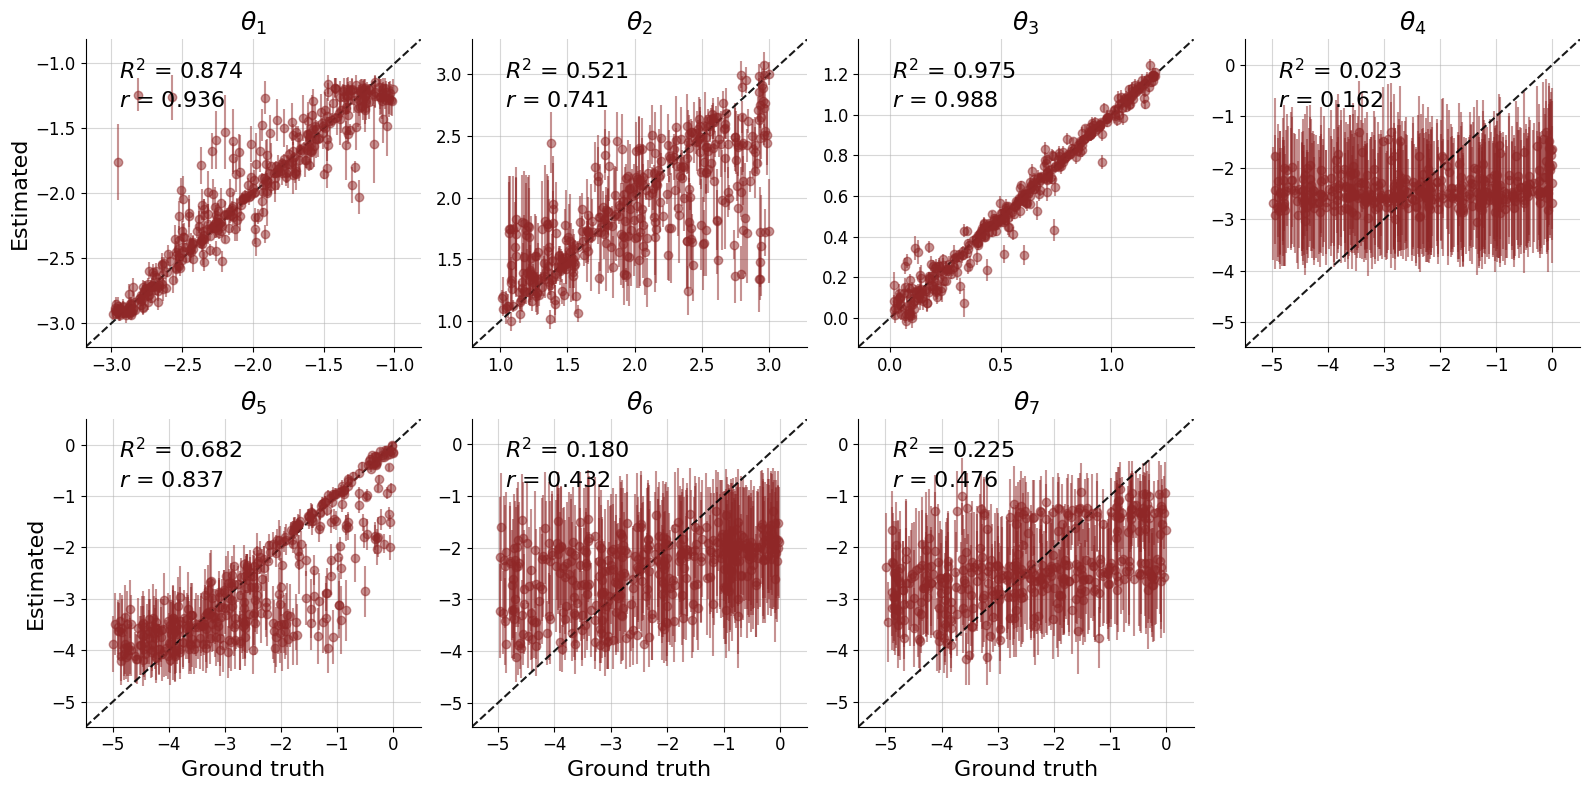

In [22]:
f = bf.diagnostics.plot_recovery(samples, conf['parameters'])